#**I. IMPORT LIBRARIES**

Here I will import the libraries that we need for this project.


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from subprocess import check_output
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from pandas.plotting import lag_plot
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error


from sklearn.metrics import mean_absolute_error, r2_score

warnings.filterwarnings('ignore')

np.random.seed(42)



# **II. DATA LOADING**

After we imported the libraries that we need, now we will load the data into a variable named df.

In [ ]:
df = pd.read_csv("Final_apple_stock_twit.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,P_mean,P_sum,twt_count,pos,neg,neutral
0,2018-01-02,42.540001,43.075001,42.314999,43.064999,40.950489,102223600,-0.093750,-3,32,1,4,27
1,2018-01-03,43.132500,43.637501,42.990002,43.057499,40.943359,118071600,-0.060000,-3,50,3,6,41
2,2018-01-04,43.134998,43.367500,43.020000,43.257500,41.133537,89738400,-0.176471,-6,34,1,7,26
3,2018-01-05,43.360001,43.842499,43.262501,43.750000,41.601860,94640000,-0.068966,-2,29,4,6,19
4,2018-01-08,43.587502,43.902500,43.482498,43.587502,41.447342,82271200,-0.086957,-4,46,2,6,38


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1250 entries, 0 to 1249
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1250 non-null   object 
 1   Open       1250 non-null   float64
 2   High       1250 non-null   float64
 3   Low        1250 non-null   float64
 4   Close      1250 non-null   float64
 5   Adj Close  1250 non-null   float64
 6   Volume     1250 non-null   int64  
 7   P_mean     1250 non-null   float64
 8   P_sum      1250 non-null   int64  
 9   twt_count  1250 non-null   int64  
 10  pos        1250 non-null   int64  
 11  neg        1250 non-null   int64  
 12  neutral    1250 non-null   int64  
dtypes: float64(6), int64(6), object(1)
memory usage: 127.1+ KB


It can be seen from the data above, because there are no missing values ​​in this data, therefore we will not do data cleaning.
Now, we will change the `Date` column to datetime because the `Date` column is an object data type.

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])

After changing the `Date` column to datetime, we will now add the year, week, and day columns.

In [ ]:
from datetime import datetime

year=[]
week_number=[]
day_of_week=[]
# Get the current date and time
for i in df.index:
  now = df.Date[i]

# Extract the week number
  a, b, c = now.isocalendar()
  year.append(a)
  week_number.append(b)
  day_of_week.append(c)

df['year'] = year
df['week_number'] = week_number
df['day_of_week'] = day_of_week


In [ ]:
df

,Date,Open,High,Low,Close,Adj Close,Volume,P_mean,P_sum,twt_count,pos,neg,neutral,year,week_number,day_of_week
0,2018-01-02,42.540001,43.075001,42.314999,43.064999,40.950489,102223600,-0.093750,-3,32,1,4,27,2018,1,2
1,2018-01-03,43.132500,43.637501,42.990002,43.057499,40.943359,118071600,-0.060000,-3,50,3,6,41,2018,1,3
2,2018-01-04,43.134998,43.367500,43.020000,43.257500,41.133537,89738400,-0.176471,-6,34,1,7,26,2018,1,4
3,2018-01-05,43.360001,43.842499,43.262501,43.750000,41.601860,94640000,-0.068966,-2,29,4,6,19,2018,1,5
4,2018-01-08,43.587502,43.902500,43.482498,43.587502,41.447342,82271200,-0.086957,-4,46,2,6,38,2018,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1245,2022-12-12,142.699997,144.500000,141.059998,144.490005,144.490005,70462700,-0.066667,-4,60,0,4,56,2022,50,1
1246,2022-12-13,149.500000,149.970001,144.240005,145.470001,145.470001,93886200,-0.039474,-3,76,3,6,67,2022,50,2
1247,2022-12-14,145.350006,146.660004,141.160004,143.210007,143.210007,82291200,-0.046875,-3,64,2,5,57,2022,50,3
1248,2022-12-15,141.110001,141.800003,136.029999,136.500000,136.500000,98931900,0.024390,2,82,9,7,66,2022,50,4


Now that we want to predict tomorrow's `Adj Close`, we will shift the data from tomorrow to the same column as today's

In [ ]:
df_reg = df.copy()
df_reg['Adj Close'] = df_reg['Adj Close'].shift(-1)
df_reg.dropna(inplace=True)
df_reg

,Date,Open,High,Low,Close,Adj Close,Volume,P_mean,P_sum,twt_count,pos,neg,neutral,year,week_number,day_of_week
0,2018-01-02,42.540001,43.075001,42.314999,43.064999,40.943359,102223600,-0.093750,-3,32,1,4,27,2018,1,2
1,2018-01-03,43.132500,43.637501,42.990002,43.057499,41.133537,118071600,-0.060000,-3,50,3,6,41,2018,1,3
2,2018-01-04,43.134998,43.367500,43.020000,43.257500,41.601860,89738400,-0.176471,-6,34,1,7,26,2018,1,4
3,2018-01-05,43.360001,43.842499,43.262501,43.750000,41.447342,94640000,-0.068966,-2,29,4,6,19,2018,1,5
4,2018-01-08,43.587502,43.902500,43.482498,43.587502,41.442593,82271200,-0.086957,-4,46,2,6,38,2018,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1244,2022-12-09,142.339996,145.570007,140.899994,142.160004,144.490005,76069500,-0.030303,-2,66,10,12,44,2022,49,5
1245,2022-12-12,142.699997,144.500000,141.059998,144.490005,145.470001,70462700,-0.066667,-4,60,0,4,56,2022,50,1
1246,2022-12-13,149.500000,149.970001,144.240005,145.470001,143.210007,93886200,-0.039474,-3,76,3,6,67,2022,50,2
1247,2022-12-14,145.350006,146.660004,141.160004,143.210007,136.500000,82291200,-0.046875,-3,64,2,5,57,2022,50,3


###**DATA SPLITTING**



In [ ]:
X = df_reg[['Open', 'High', 'Low', 'Close', 'Volume', 'twt_count', 'pos', 'neg', 'neutral']]
y = df_reg['Adj Close']

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1249 entries, 0 to 1248
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1249 non-null   float64
 1   High       1249 non-null   float64
 2   Low        1249 non-null   float64
 3   Close      1249 non-null   float64
 4   Volume     1249 non-null   int64  
 5   twt_count  1249 non-null   int64  
 6   pos        1249 non-null   int64  
 7   neg        1249 non-null   int64  
 8   neutral    1249 non-null   int64  
dtypes: float64(4), int64(5)
memory usage: 97.6 KB


In [ ]:
from sklearn.model_selection import train_test_split,GridSearchCV
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, shuffle=False)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(999, 9)
(250, 9)
(999,)
(250,)


### **SCALING**

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

In [ ]:
num_pipeline = Pipeline([
        ('scaler', MinMaxScaler())
    ])

X_train_tr = num_pipeline.fit_transform(pd.DataFrame(X_train[['Open', 'High', 'Low', 'Close', 'Volume', 'twt_count', 'pos', 'neg', 'neutral']]))
X_train_tr

array([[0.04509907, 0.04560741, 0.04866813, ..., 0.01123596, 0.03738318,
        0.03065693],
       [0.04918175, 0.04946809, 0.05348855, ..., 0.03370787, 0.05607477,
        0.05109489],
       [0.04919896, 0.04761496, 0.05370278, ..., 0.01123596, 0.06542056,
        0.02919708],
       ...,
       [0.95858746, 0.98194918, 0.97700492, ..., 0.1011236 , 0.07476636,
        0.06131387],
       [0.9873213 , 0.99320518, 0.96586447, ..., 0.02247191, 0.06542056,
        0.05547445],
       [0.92289404, 0.94056278, 0.95829468, ..., 0.04494382, 0.03738318,
        0.04525547]])

In [ ]:
X_test_tr = num_pipeline.transform(X_test)
X_test_tr

array([[0.91152457, 0.9207275 , 0.94236955, ..., 0.04494382, 0.07476636,
        0.05693431],
       [0.93412577, 0.93870962, 0.95422407, ..., 0.02247191, 0.00934579,
        0.0350365 ],
       [0.94432384, 0.95696634, 0.97586228, ..., 0.06741573, 0.03738318,
        0.03211679],
       ...,
       [0.78211889, 0.77927246, 0.77654793, ..., 0.03370787, 0.05607477,
        0.08905109],
       [0.75352289, 0.75655456, 0.75455263, ..., 0.02247191, 0.04672897,
        0.07445255],
       [0.72430666, 0.72319835, 0.71791759, ..., 0.1011236 , 0.06542056,
        0.08759124]])

# **III. MACHINE LEARNING MODELS**

In this section, we will test various model algorithm then we will choose the best model to deploy.

##**MODEL DEFINITION**

For this section, I will use several models from machine learning, namely :

- Linear Regression.
- Decision Tree.
- Random Forest.
- Support Vector Machine.

Also later in this section I will do a GridSearch based on the best models I trained.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

In [ ]:
from sklearn.model_selection import train_test_split,GridSearchCV

#####**MODEL DEFINITION**

In [ ]:
lin_reg = LinearRegression()
dtr = DecisionTreeRegressor()
rfr = RandomForestRegressor()
svr = SVR()

**LINEAR REGRESSION**



In [ ]:
lin_reg.fit(X_train_tr,y_train)
pred_train_lr = lin_reg.predict(X_train_tr)
pred_test_lr = lin_reg.predict(X_test_tr)

print("-"*20,"TRAINING","-"*20)
print("Mean absolute error:",mean_absolute_error(y_train,pred_train_lr))
print('RMSE :', np.sqrt(mean_squared_error(y_train, pred_train_lr)))
print("-"*20,"TEST","-"*20)
print("Mean absolute error:",mean_absolute_error(y_test,pred_test_lr))
print('RMSE :', np.sqrt(mean_squared_error(y_test, pred_test_lr)))


-------------------- TRAINING --------------------
Mean absolute error: 1.2161885128570857
RMSE : 1.7493284565373806
-------------------- TEST --------------------
Mean absolute error: 2.768414099330313
RMSE : 3.5326573997582336


For MAE and RMSE test scores, the best is close to 0.
From the results of the linear regression model above, the MAE value is 2.7 and the RMSE is 3.5 which means that the linear regression model is overfit, but not too significant so we can consider this model to be used.

#####**DECISION TREE REGRESSOR**

In [ ]:
dtr.fit(X_train,y_train)
pred_train_dt = dtr.predict(X_train)
pred_test_dt = dtr.predict(X_test)

print("-"*20,"TRAINING","-"*20)
print("Mean absolute error:",mean_absolute_error(y_train,pred_train_dt))
print('RMSE :', np.sqrt(mean_squared_error(y_train, pred_train_dt)))
print("-"*20,"TEST","-"*20)
print("Mean absolute error:",mean_absolute_error(y_test,pred_test_dt))
print('RMSE :', np.sqrt(mean_squared_error(y_test, pred_test_dt)))



-------------------- TRAINING --------------------
Mean absolute error: 0.0
RMSE : 0.0
-------------------- TEST --------------------
Mean absolute error: 4.164898895263672
RMSE : 5.217713533702885


From the results of the decision tree regressor model above, the MAE value is 4.1 and the RMSE is 5.2 which means that the decision tree regressor model is quite overfit, this model is not better than the linear regression model.

#####**RANDOM FOREST REGRESSOR**

In [ ]:
rfr.fit(X_train,y_train)
pred_train_rf = rfr.predict(X_train)
pred_test_rf = rfr.predict(X_test)

print("="*20,"TRAINING","="*20)
print("Mean absolute error:",mean_absolute_error(y_train,pred_train_rf))
print('RMSE :', np.sqrt(mean_squared_error(y_train, pred_train_rf)))

print("="*20,"TEST","="*20)
print("Mean absolute error:",mean_absolute_error(y_test,pred_test_rf))
print('RMSE :', np.sqrt(mean_squared_error(y_test, pred_test_rf)))



==================== TRAINING ====================
Mean absolute error: 0.5023617194770454
RMSE : 0.7693747452029861
==================== TEST ====================
Mean absolute error: 3.184537073059082
RMSE : 3.915814266820376


From the results of the Random Forest regressor model above, the MAE value is 3.1 and the RMSE is 3.9 which means that the Random Forest regressor model is quite overfit, this model is worse than the linear regression model, but better than the decision tree regressor.

**SUPPORT MACHINE REGRESSOR**

In [ ]:
svr.fit(X_train,y_train)
pred_train_svr = svr.predict(X_train)
pred_test_svr = svr.predict(X_test)

print("="*20,"TRAINING","="*20)
print("Mean absolute error:",mean_absolute_error(y_train,pred_train_svr))
print('RMSE :', np.sqrt(mean_squared_error(y_train, pred_train_svr)))

print("="*20,"TEST","="*20)
print("Mean absolute error:",mean_absolute_error(y_test,pred_test_svr))
print('RMSE :', np.sqrt(mean_squared_error(y_test, pred_test_svr)))


==================== TRAINING ====================
Mean absolute error: 33.74513454474825
RMSE : 41.44443465230446
==================== TEST ====================
Mean absolute error: 84.60915405136564
RMSE : 85.55142364231281


From the results of the support machine regressor model above, the MAE value is 41.4 and the RMSE is 85.5 which means that the support machine regressor model is very overfit, this model is the worst model compare to 3 previous models.

#####**GRID SEARCH**

Now we enter the search grid section. Grid search refers to a technique used to identify optimal hyperparameters for a model. Unlike parameters, finding hyperparameters in training data is unattainable. Therefore, to find the right hyperparameters, we create a model for each combination of hyperparameters.

Grid search is considered a very traditional method of hyperparameter optimization because we are essentially "forcing" all possible combinations. The model that boasts the best accuracy is naturally considered the best.

For GridSearch, I'll be using Linear Regression as the model to tune.

**LINEAR REGRESSION TUNING**

In [ ]:
params = [
    {'fit_intercept': [True,False],                           
     'normalize': [True,False],         
    }         
  ]

grid_search = GridSearchCV(lin_reg, params, cv=5,
                           scoring='r2',
                           return_train_score=True)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LinearRegression(),
             param_grid=[{'fit_intercept': [True, False],
                          'normalize': [True, False]}],
             return_train_score=True, scoring='r2')

In [ ]:
print('Best Parameter :', grid_search.best_params_)
print('Best Score     :', grid_search.best_score_)

Best Parameter : {'fit_intercept': True, 'normalize': True}
Best Score     : 0.9636579975004796


In [ ]:
linreg_tuned = grid_search.best_estimator_
linreg_tuned.fit(X_train, y_train)

LinearRegression(normalize=True)

In [ ]:
X_train.shape, y_train.shape

((999, 9), (999,))

In [ ]:
X_test.shape, y_test.shape

((250, 9), (250,))

> Model Performance:

In [ ]:
pred_train_linreg = linreg_tuned.predict(X_train)
pred_test_linreg = linreg_tuned.predict(X_test)

print("="*20,"TRAINING","="*20)
print("Mean absolute error:",mean_absolute_error(y_train,pred_train_linreg))
print("Mean Squared Error :",np.sqrt(mean_squared_error(y_train, pred_train_linreg)))
print(' ')
print("="*20,"TEST","="*20)
print("Mean absolute error:",mean_absolute_error(y_test,pred_test_linreg))
print("Mean Squared Error :",np.sqrt(mean_squared_error(y_test, pred_test_linreg)))

==================== TRAINING ====================
Mean absolute error: 1.2161885128570862
Mean Squared Error : 1.7493284565373812
 
==================== TEST ====================
Mean absolute error: 2.76841409933032
Mean Squared Error : 3.5326573997582433


The results of the linear regression model that we have tuned have better MAE and RMSE values ​​than the linear regression before tuning, but the difference in scores is very thin.

#### **PIPELINE MODEL**

After tuning the linear regression model, now I will try to use pipeline here to make the inferencing process faster.



In [ ]:
all_process = Pipeline([
    ("preprocessing", num_pipeline),
    ("regression", linreg_tuned)
])
all_process.fit(X_train, y_train)

Pipeline(steps=[('preprocessing', Pipeline(steps=[('scaler', MinMaxScaler())])),
                ('regression', LinearRegression(normalize=True))])

#### **PLOTTING MODEL PERFORMANCE**

In [ ]:
X_test["Forecast_test"] = all_process.predict(X_test)

In [ ]:
y_test = pd.DataFrame(y_test)

In [ ]:
X_test["Adj Close"] = y_test["Adj Close"]

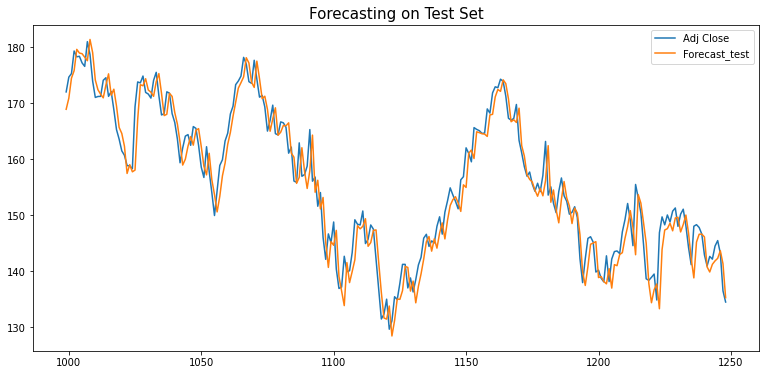

In [ ]:
X_test[["Adj Close", "Forecast_test"]].plot(figsize=(13,6))
plt.title("Forecasting on Test Set", size=15)
plt.show()

It can be seen from the plot above that `Adj Close` and `Forecast_Test` have almost the same line.

#### **INFERENCING**

In [ ]:
data = df.iloc[-1:]
data = data[['Open', 'High', 'Low', 'Close', 'Volume', 'twt_count', 'pos', 'neg', 'neutral']]
data

,Open,High,Low,Close,Volume,twt_count,pos,neg,neutral
1249,136.690002,137.649994,133.729996,134.509995,160080100,88,5,16,67


> Predicting Tomorow's Price

In [ ]:
forecast = all_process.predict(data)
forecast

array([133.32146132])

# **IV. SAVING MODEL**

In [ ]:
import pickle as pkl

In [ ]:
pickle.dump(all_process, open("preprocess.pkl", "wb"))

In [ ]:
model = pickle.load(open("preprocess.pkl", "rb"))

#**V. CONCLUSION**

- We use all four models to find which machine learning model is the best, namely Linear Regression, Decision Tree, Random Forest, Support Vector Machine. Out of the four models the best is linear regression, and after we have tuned the MAE and RMSE values ​​of the tuned linear regression are better than those before tuning although the changes in values ​​are not too significant.